In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
 
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
df = pd.read_csv("compas-scores-two-years.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [3]:
df['is_med_or_high_risk']  = (df['decile_score']>=5).astype(int)
np.mean(df['is_med_or_high_risk']==df['two_year_recid'])
np.mean(df['two_year_recid'])

0.6537288605489326

0.45065151095092876

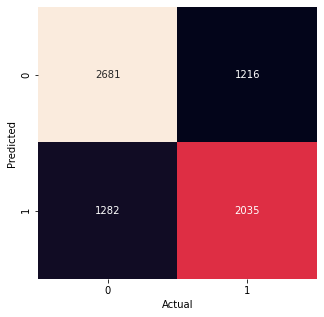

In [4]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'])
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt="d", cbar=False)

In [5]:
[[tn , fp],[fn , tp]]  = confusion_matrix(df['two_year_recid'], df['is_med_or_high_risk'])
print("True negatives:  ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives:  ", tp)

True negatives:   2681
False positives:  1282
False negatives:  1216
True positives:   2035


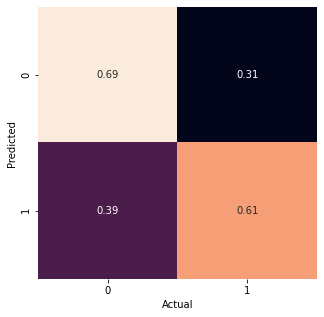

In [6]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'], normalize='index')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

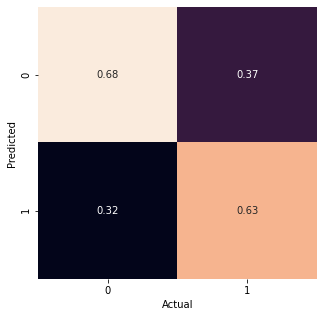

In [7]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'], normalize='columns')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

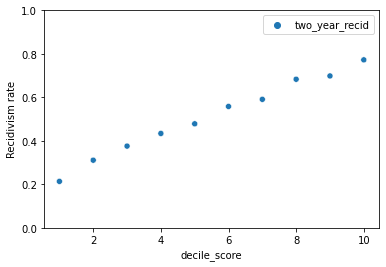

In [8]:
d = df.groupby('decile_score').agg({'two_year_recid': 'mean'})
# plot
sns.scatterplot(data=d);
plt.ylim(0,1);
plt.ylabel('Recidivism rate');

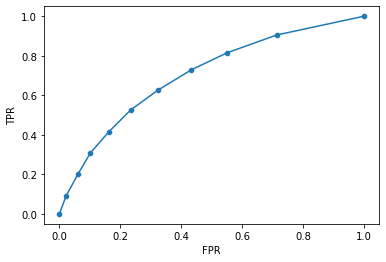

In [10]:
fpr, tpr, thresholds = roc_curve(df['two_year_recid'], df['decile_score'])
sns.scatterplot(x=fpr, y=tpr, );
sns.lineplot(x=fpr, y=tpr);
plt.ylabel("TPR");
plt.xlabel("FPR");

In [11]:
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [12]:
df = df[df.race.isin(["African-American","Caucasian"])]
# compare accuracy
(df['two_year_recid']==df['is_med_or_high_risk']).astype(int).groupby(df['race']).mean()

race
African-American    0.638258
Caucasian           0.669927
dtype: float64

In [13]:
df[df['is_med_or_high_risk']==1]['two_year_recid'].groupby(df['race']).mean()

race
African-American    0.629715
Caucasian           0.591335
Name: two_year_recid, dtype: float64

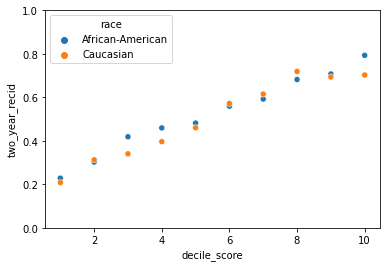

In [14]:
# calibration plot
d = pd.DataFrame(df.groupby(['decile_score','race']).agg({'two_year_recid': 'mean'}))
d = d.reset_index()
im = sns.scatterplot(data=d, x='decile_score', y='two_year_recid', hue='race');
im.set(ylim=(0,1));

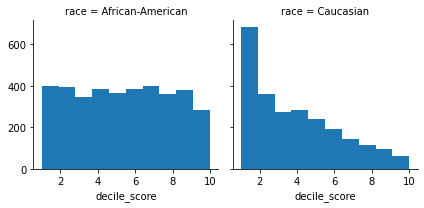

In [15]:
# frequency plot
g = sns.FacetGrid(df, col="race", margin_titles=True);
g.map(plt.hist, "decile_score", bins=10);

In [16]:
# base rates
df.groupby('race').agg({'two_year_recid': 'mean',  
                        'is_med_or_high_risk': 'mean', 
                        'decile_score': 'mean'})

,two_year_recid,is_med_or_high_risk,decile_score
race,,,
African-American,0.514340,0.588203,5.368777
Caucasian,0.393643,0.348003,3.735126


In [17]:
black_threshold  = 6
df_black = df[df['race']=="African-American"].copy()
df_black['is_med_or_high_risk'] = (df_black['decile_score']>=black_threshold).astype(int)
[[tn , fp],[fn , tp]]  = confusion_matrix(df_black['two_year_recid'], df_black['is_med_or_high_risk'])
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Positive predictive value (Black): ", tp/(tp+fp))
print("Negative predictive value (Black): ", tn/(tn+fn))

False positive rate (Black)      :  0.34317548746518106
False negative rate (Black)      :  0.37243556023145713
Positive predictive value (Black):  0.6594803758982863
Negative predictive value (Black):  0.6248012718600954


In [18]:
white_threshold  = 4
df_white = df[df['race']=="Caucasian"].copy()
df_white['is_med_or_high_risk'] = (df_white['decile_score']>=white_threshold).astype(int)
[[tn , fp],[fn , tp]]  = confusion_matrix(df_white['two_year_recid'], df_white['is_med_or_high_risk'])
print("False positive rate (white)      : ", fp/(fp+tn))
print("False negative rate (white)      : ", fn/(fn+tp))
print("Positive predictive value (white): ", tp/(tp+fp))
print("Negative predictive value (white): ", tn/(tn+fn))

False positive rate (white)      :  0.35013440860215056
False negative rate (white)      :  0.36024844720496896
Positive predictive value (white):  0.5425812115891132
Negative predictive value (white):  0.7353612167300381
